# Predictive Power of LM Surprisal

We fit regression models to determine to what extent accounting for surprisal improves a linear model's predictions of reading time data, relative to a model fit based on control predictors of word length and frequency.

In [69]:
all_data <- read.csv("data/surprisal_data/combined_surprisal_rts.csv")
set.seed(85)

## Dundee Corpus

Fitting models for eyetracking data (Dundee corpus). To account for spillover effects, we use the previous tokens' features as predictors.

In this analysis, we include the number of times a word was split by the tokenizer as a control predictor.

In [3]:
et_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1'

et_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + log_freq * word_length + prev_freq_1 * prev_len_1'

In [4]:
predictive_power <- function(data, control_formula, surprisal_formula, tokenization, log_values) {
    control_model <- glm(control_formula, data, family = 'gaussian')
    surprisal_model <- glm(surprisal_formula, data, family = 'gaussian')
    if (log_values) {
        print(tokenization)
        print(summary(surprisal_model)$coefficients)
    }
    (logLik(surprisal_model) - logLik(control_model)) / nrow(data)
}

In [5]:
dundee_et <- all_data[all_data$corpus == "dundee",]
dundee_orth <- dundee_et[dundee_et$tokenization == "orthographic", ]
dundee_bpe <- dundee_et[dundee_et$tokenization == "bpe", ]
dundee_morph <- dundee_et[dundee_et$tokenization == "morphological", ]

In [6]:
effect_size <- function(control_formula, surprisal_formula, data) {
    surprisal_r_sq <- summary(lm(surprisal_formula, data))$r.squared
    control_r_sq <- summary(lm(control_formula, data))$r.squared
    (surprisal_r_sq - control_r_sq)/ (1 - surprisal_r_sq)
}

In [7]:
dundee_predictive_power <- data.frame(
    orthographic=predictive_power(dundee_orth, et_control_formula, et_surprisal_formula, "orthographic", TRUE),
    bpe=predictive_power(dundee_bpe, et_control_formula, et_surprisal_formula, "bpe", TRUE),
    morphological=predictive_power(dundee_morph, et_control_formula, et_surprisal_formula, "morphological", TRUE)
)


[1] "orthographic"
                          Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            226.5767602  4.2446484  53.379394 0.000000e+00
surprisal                2.3164958  0.1187946  19.500017 2.968882e-84
prev_surprisal_1         2.1488704  0.1168170  18.395183 3.161045e-75
log_freq                 7.3586537  0.9891392   7.439452 1.033377e-13
word_length             -0.9833156  0.6897894  -1.425530 1.540126e-01
prev_freq_1              7.0203932  0.9852294   7.125643 1.055251e-12
prev_len_1              -8.8801142  0.6977781 -12.726272 5.071518e-37
log_freq:word_length    -2.7185452  0.1667011 -16.307903 1.414002e-59
prev_freq_1:prev_len_1  -0.9597138  0.1690259  -5.677910 1.373903e-08
[1] "bpe"
                          Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            225.9530564  4.2375587  53.321517 0.000000e+00
surprisal                2.4127654  0.1176685  20.504766 6.580384e-93
prev_surprisal_1         2.0754128  0.1152422  18.009141 3.41

## Natural Stories Corpus

The only major difference is that this corpus reports self-paced reading times, where spillover effects occur over the previous three words.

In [568]:
summary(lm(spr_surprisal_formula, natural_stories_orth))$r.squared

[1] 0.1383463

In [569]:
summary(lm(spr_surprisal_formula, natural_stories_bpe))$r.squared

[1] 0.1404007

In [570]:
summary(lm(spr_surprisal_formula, natural_stories_morph))$r.squared

[1] 0.1379354

In [8]:
spr_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

spr_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + prev_surprisal_2 + prev_surprisal_3 + log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

In [9]:
natural_stories_spr <- all_data[all_data$corpus == "natural_stories", ]
natural_stories_orth <- natural_stories_spr[natural_stories_spr$tokenization == "orthographic", ]
natural_stories_bpe <- natural_stories_spr[natural_stories_spr$tokenization == "bpe", ]
natural_stories_morph <- natural_stories_spr[natural_stories_spr$tokenization == "morphological", ]

In [576]:
natural_stories_predictive_power <- data.frame(
    orthographic=predictive_power(natural_stories_orth, spr_control_formula, spr_surprisal_formula, "orthographic", TRUE),
    bpe=predictive_power(natural_stories_bpe, spr_control_formula, spr_surprisal_formula, "bpe", TRUE),
    morphological=predictive_power(natural_stories_morph, spr_control_formula, spr_surprisal_formula, "morphological", TRUE)
)


[1] "orthographic"
                           Estimate Std. Error    t value     Pr(>|t|)
(Intercept)            322.12768610  7.0103438 45.9503405 0.000000e+00
surprisal                0.91267414  0.1199950  7.6059336 3.237776e-14
prev_surprisal_1         0.70237692  0.1211054  5.7997179 6.961480e-09
prev_surprisal_2         0.24169368  0.1160900  2.0819512 3.738678e-02
prev_surprisal_3         0.33941011  0.1135599  2.9888196 2.811271e-03
log_freq                 4.02679300  1.0505539  3.8330190 1.278001e-04
word_length             -4.10153914  0.7849861 -5.2249832 1.797078e-07
prev_freq_1              2.04327381  1.0879863  1.8780327 6.042237e-02
prev_len_1              -2.34998454  0.8089215 -2.9050835 3.684196e-03
prev_freq_2             -0.34790474  1.0462153 -0.3325365 7.394951e-01
prev_len_2               0.26049465  0.7991679  0.3259573 7.444674e-01
prev_freq_3              1.30780073  1.0108546  1.2937575 1.957961e-01
prev_len_3              -0.83237816  0.7886703 -1.0554196 

## Predictive Power (Table 1)

The tables report the per-token $\Delta LogLik$. These show that incorporating surprisal into the control models improved their ability to predict reading times.

In [577]:
dundee_predictive_power

orthographic,bpe,morphological
<dbl>,<dbl>,<dbl>
0.01034982,0.010752,0.01025458


In [578]:
natural_stories_predictive_power

orthographic,bpe,morphological
<dbl>,<dbl>,<dbl>
0.008818827,0.01001237,0.008580439


This is in line with the values for the 5-gram models from Wilcox et al (2020), especially accounting for differences in the training corpora. There does not seem to be a major difference between the models' predictive power. 

### Computing effect size (Cohen's f^2)

Dundee corpus:

In [661]:
effect_size(et_control_formula, et_surprisal_formula, dundee_orth)

[1] 0.02091535

In [658]:
effect_size(et_control_formula, et_surprisal_formula, dundee_bpe)

[1] 0.02173687

In [659]:
effect_size(et_control_formula, et_surprisal_formula, dundee_morph)

[1] 0.02072093

Natural Stories:

In [660]:
effect_size(spr_control_formula, spr_surprisal_formula, natural_stories_orth)

[1] 0.01779412

In [662]:
effect_size(spr_control_formula, spr_surprisal_formula, natural_stories_bpe)

[1] 0.02022658

In [663]:
effect_size(spr_control_formula, spr_surprisal_formula, natural_stories_morph)

[1] 0.01730897

## Cross-Validation

These metrics are reported for the entire dataset, so we now evaluate regression models against held-out data. For each model, we now report $\Delta LogLik$ for each run of 10-fold cross-validation.

In [10]:
test_data_loglik <- function(model, test_data) {
    predictions <- predict(model, test_data)
    stdev <- sigma(model)
    dnorm(test_data$rt, predictions, stdev, log = TRUE)
}

In [11]:
cross_validate <- function(data, indices, control_formula, surprisal_formula) {
    data<-data[indices,]
    folds <- cut(seq(1,nrow(data)),breaks=10,labels=FALSE) # this is the same for each model
    predictive_power <- seq(1:10)
    for(i in 1:10){
        test_indices <- which(folds==i)
        test_data <- data[test_indices, ]
        train_data <- data[-test_indices, ]
        fold_control_model <- glm(control_formula, train_data, family = 'gaussian')
        fold_surprisal_model <- glm(surprisal_formula, train_data, family = 'gaussian')
        surprisal_diff <- test_data_loglik(fold_surprisal_model, test_data) - test_data_loglik(fold_control_model, test_data)
        predictive_power[i] <- mean(surprisal_diff) # summed per-token log likelihoods, divided by number of tokens 
        }
    predictive_power
}

In [12]:
corpus_cv <- function(orth_data, bpe_data, morph_data, control_formula, surprisal_formula) {
    shuffled_indices <- sample(nrow(orth_data))
    cv_results <- data.frame(
      orthographic = cross_validate(orth_data, shuffled_indices, control_formula, surprisal_formula),
       bpe = cross_validate(bpe_data, shuffled_indices, control_formula, surprisal_formula),
       morphological = cross_validate(morph_data, shuffled_indices, control_formula, surprisal_formula)
    )
    cv_results
}

In [673]:
dundee_cv_results <- corpus_cv(dundee_orth, dundee_bpe, dundee_morph, et_control_formula, et_surprisal_formula)
natural_stories_cv_results <- corpus_cv(natural_stories_orth, natural_stories_bpe, natural_stories_morph,
                                        spr_control_formula, spr_surprisal_formula)


In [674]:
dundee_cv_results$corpus = 'Dundee'
natural_stories_cv_results$corpus = 'Natural Stories'
combined_cv <- rbind(dundee_cv_results, natural_stories_cv_results)

In [13]:
library(ggplot2)
library(reshape2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [676]:
combined_cv <- melt(combined_cv) %>% rename(Tokenization = variable)

Using corpus as id variables



In [677]:
# Relabeling columns for plotting, courtesy of...ChatGPT
combined_cv <- combined_cv %>%
  mutate(Tokenization = ifelse(Tokenization == "orthographic", "Orthographic",
                              ifelse(Tokenization == "bpe", "BPE",
                                     ifelse(Tokenization == "morphological", "Morphological", Tokenization))))


In [678]:
options(repr.plot.width=14, repr.plot.height=12)

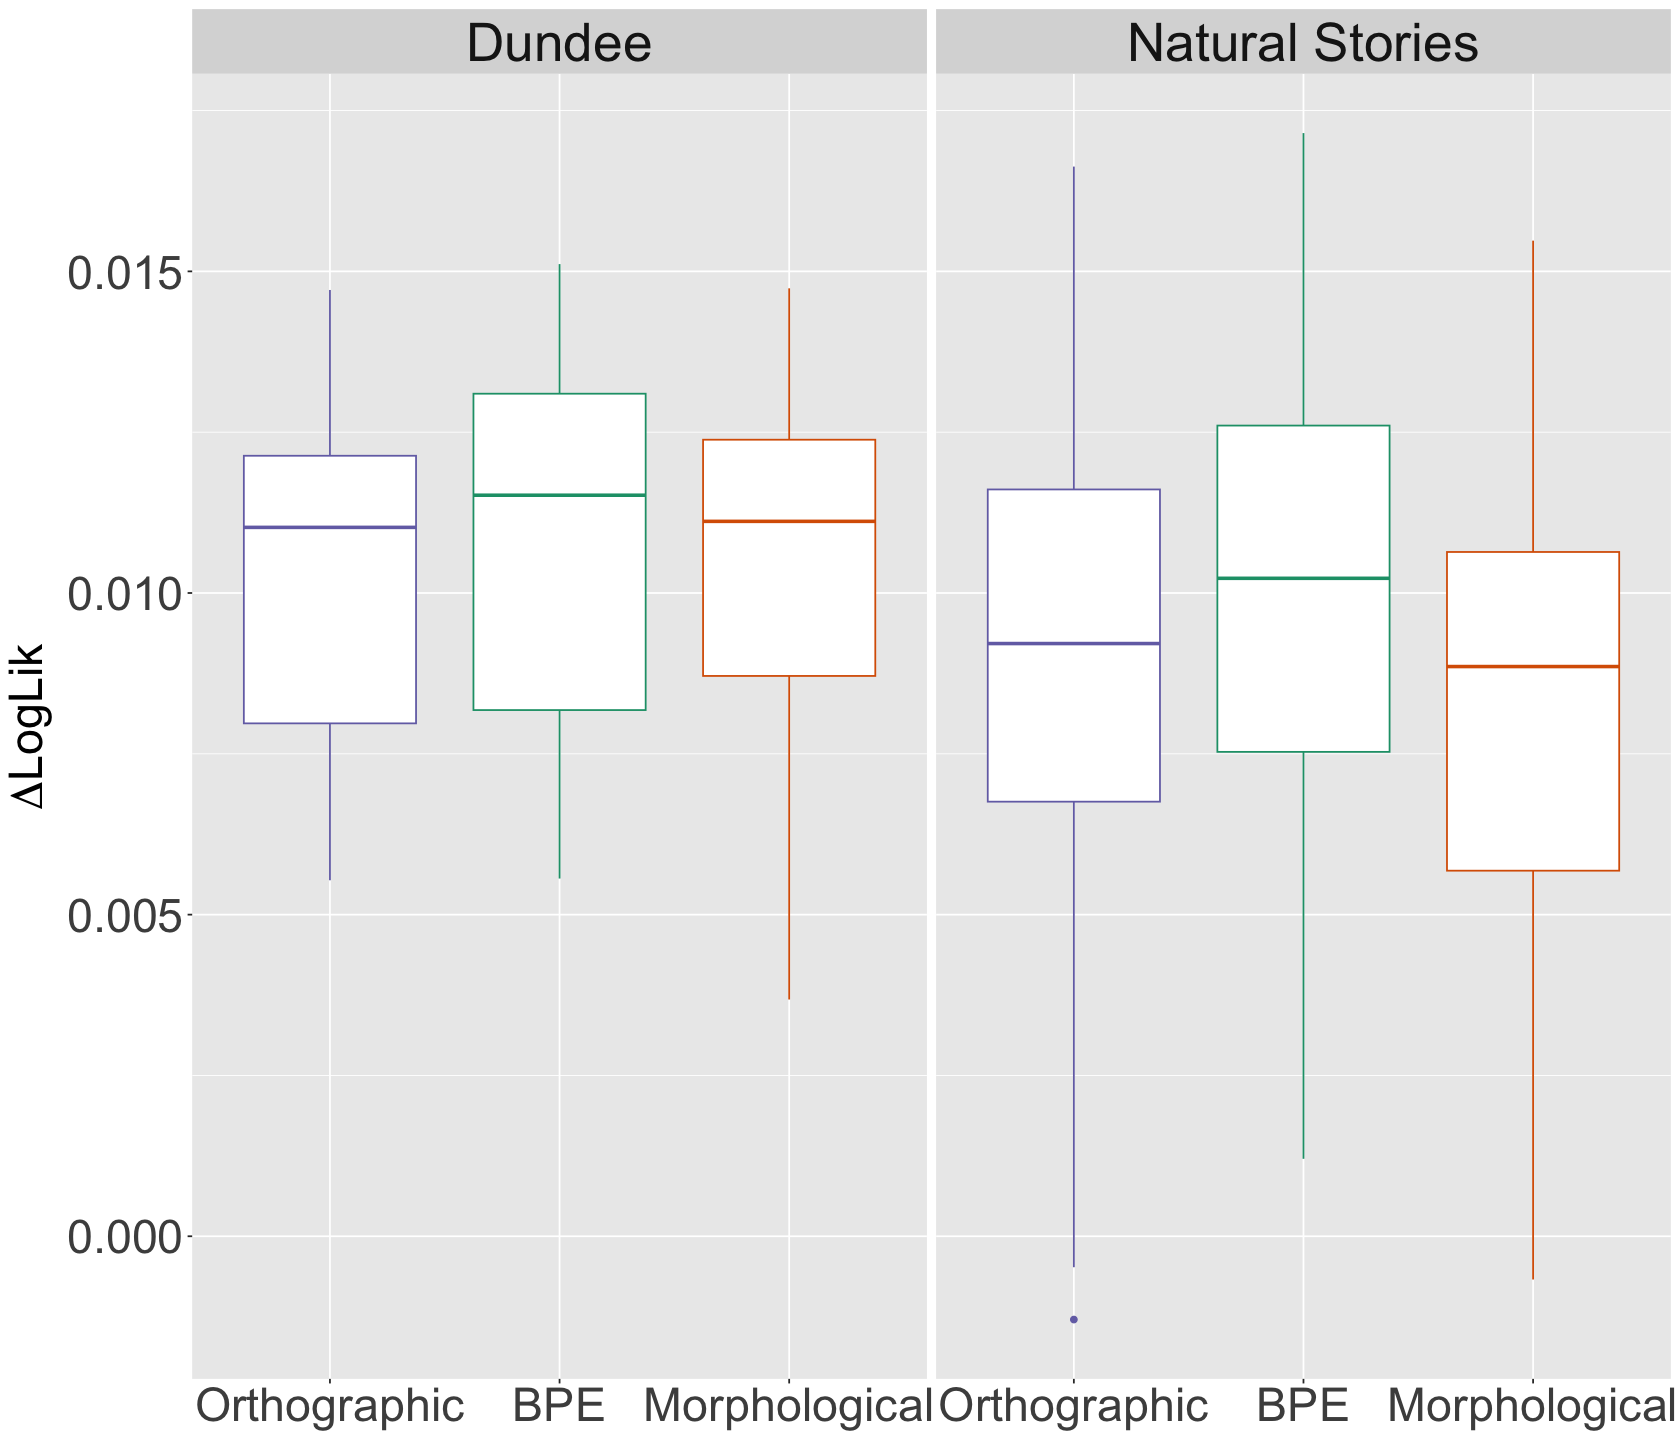

In [679]:
custom_order <- c("Orthographic", "BPE", "Morphological")

plt <- ggplot(combined_cv, aes(x = factor(Tokenization, levels = custom_order), y = value, color = Tokenization)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik")))
theme <- theme(axis.title = element_text(size = 28), axis.title.x = element_blank(), axis.text.x = element_text(size = 28),
               axis.text.y = element_text(size = 28),
               strip.text.x = element_text(size = 32), legend.position = "none")
plt + facet_grid(. ~corpus) + theme + labs(fill = "Tokenization") + scale_color_brewer(palette = "Dark2")


## Statistical Significance Testing

We use a nonparametric test since we have 10 datapoints and the models were fit independently of one another. A  p-value above the cutoff should show there is no statistically significant difference between the $\Delta LogLik$ estimated for the folds for the two subword tokenization methods relative to predictions over orthographic words.

The models trained on the BPE tokenizer output and the morphological segmenter's output both did not have statistically significant differences in their predictive power compared to just using orthographic words.

### Dundee

In [630]:
wilcox.test(dundee_cv_results$orthographic, dundee_cv_results$bpe)


	Wilcoxon rank sum exact test

data:  dundee_cv_results$orthographic and dundee_cv_results$bpe
W = 43, p-value = 0.6305
alternative hypothesis: true location shift is not equal to 0


In [631]:
wilcox.test(dundee_cv_results$orthographic, dundee_cv_results$morphological)


	Wilcoxon rank sum exact test

data:  dundee_cv_results$orthographic and dundee_cv_results$morphological
W = 50, p-value = 1
alternative hypothesis: true location shift is not equal to 0


### Natural Stories

In [632]:
wilcox.test(natural_stories_cv_results$orthographic, natural_stories_cv_results$bpe)


	Wilcoxon rank sum exact test

data:  natural_stories_cv_results$orthographic and natural_stories_cv_results$bpe
W = 41, p-value = 0.5288
alternative hypothesis: true location shift is not equal to 0


In [633]:
wilcox.test(natural_stories_cv_results$orthographic, natural_stories_cv_results$morphological)


	Wilcoxon rank sum exact test

data:  natural_stories_cv_results$orthographic and natural_stories_cv_results$morphological
W = 53, p-value = 0.8534
alternative hypothesis: true location shift is not equal to 0


## Analysis for Mono and Multimorphemic Words

We want to determine the predictive power of surprisal based on how times a word gets split by the tokenizers.

In [70]:
pred_power_by_split <- function(data, control_formula, surprisal_formula, tokenization) {
    data <- data[data$tokenization == tokenization,]
    no_split <- data[data$num_tokens == 1,]
    split <- data[data$num_tokens > 1,]
    data.frame(no_split = predictive_power(no_split, control_formula, surprisal_formula, tokenization, FALSE),
    split = predictive_power(split, control_formula, surprisal_formula, tokenization, FALSE))
}

We redefine the formulas since we don't want to control for the number of tokens.

### Dundee Corpus

In [71]:
pred_power_by_split(dundee_et, et_control_formula, et_surprisal_formula, "bpe")

no_split,split
<dbl>,<dbl>
0.01060325,0.00939214


In [72]:
pred_power_by_split(dundee_et, et_control_formula, et_surprisal_formula, "morphological")

no_split,split
<dbl>,<dbl>
0.009270833,0.01269973


In [130]:
cv_by_split <- function(data, control_formula, surprisal_formula, tokenization, split_col) {
    data <- data[data$tokenization == tokenization,]
    no_split <- data[data[[split_col]] == 1,]
    split <- data[data[[split_col]] > 1,]
    shuffled_no_split <- sample(nrow(no_split))
    shuffled_split <- sample(nrow(split))
    data.frame(whole = cross_validate(no_split, shuffled_no_split, control_formula, surprisal_formula),
    split = cross_validate(split, shuffled_split, control_formula, surprisal_formula),
    tokenization_method = tokenization
    )
}


In [132]:
bpe_cv <- cv_by_split(dundee_et, et_control_formula, et_surprisal_formula, "bpe", "num_tokens")
morph_cv <- cv_by_split(dundee_et, et_control_formula, et_surprisal_formula, "morphological", "num_tokens")
combined_cv <- rbind(bpe_cv, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)

Using tokenization_method as id variables



In [133]:
combined_cv <- combined_cv %>%
  mutate(tokenization_method = ifelse(tokenization_method == "orthographic", "Orthographic",
                              ifelse(tokenization_method == "bpe", "BPE",
                                     ifelse(tokenization_method == "morphological", "Morphological", tokenization_method))))
combined_cv <- combined_cv %>% 
         mutate(split = ifelse(split == "whole", "Whole",
                             ifelse(split == "split", "Split", split)))

In [134]:
options(repr.plot.width=6, repr.plot.height=8)

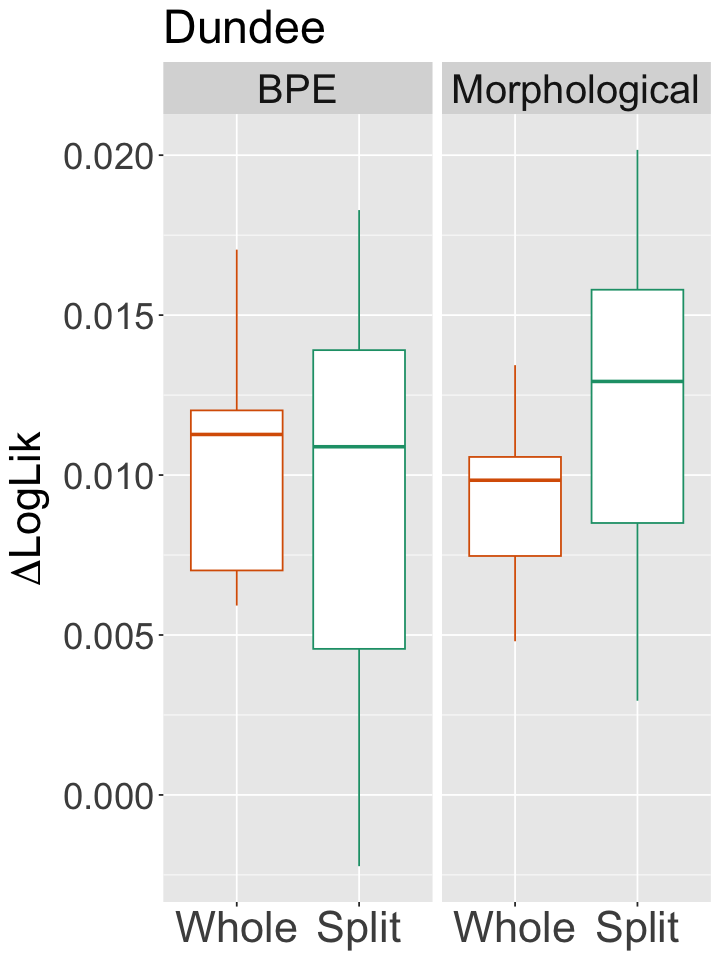

In [135]:
plt <- ggplot(combined_cv, aes(x = factor(split, levels = c(sort(unique(split), decreasing = TRUE))), y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + labs(title = "Dundee") + theme(plot.title = 
                                                                                       element_text(size = 28)) 

theme <- theme(axis.title = element_text(size = 26), axis.title.x = element_blank(), axis.text.x = element_text(size = 26),
               axis.text.y = element_text(size = 22),
               strip.text.x = element_text(size = 24), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [136]:
wilcox.test(bpe_cv$whole, bpe_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  bpe_cv$whole and bpe_cv$split
W = 51, p-value = 0.4853
alternative hypothesis: true location shift is greater than 0


In [137]:
wilcox.test(morph_cv$whole, morph_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  morph_cv$whole and morph_cv$split
W = 32, p-value = 0.9173
alternative hypothesis: true location shift is greater than 0


### Natural Stories Corpus

In [138]:
spr_control_formula <- 'rt ~ log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

spr_surprisal_formula <- 'rt ~ surprisal + prev_surprisal_1 + prev_surprisal_2 + prev_surprisal_3 + log_freq * word_length + prev_freq_1 * prev_len_1 + prev_freq_2 * prev_len_2 + prev_freq_3 * prev_len_3'

In [139]:
pred_power_by_split(natural_stories_spr, spr_control_formula, spr_surprisal_formula, "bpe")

no_split,split
<dbl>,<dbl>
0.01147332,0.00426006


In [140]:
pred_power_by_split(natural_stories_spr, spr_control_formula, spr_surprisal_formula, "morphological")

no_split,split
<dbl>,<dbl>
0.009270199,0.00782449


Using tokenization_method as id variables



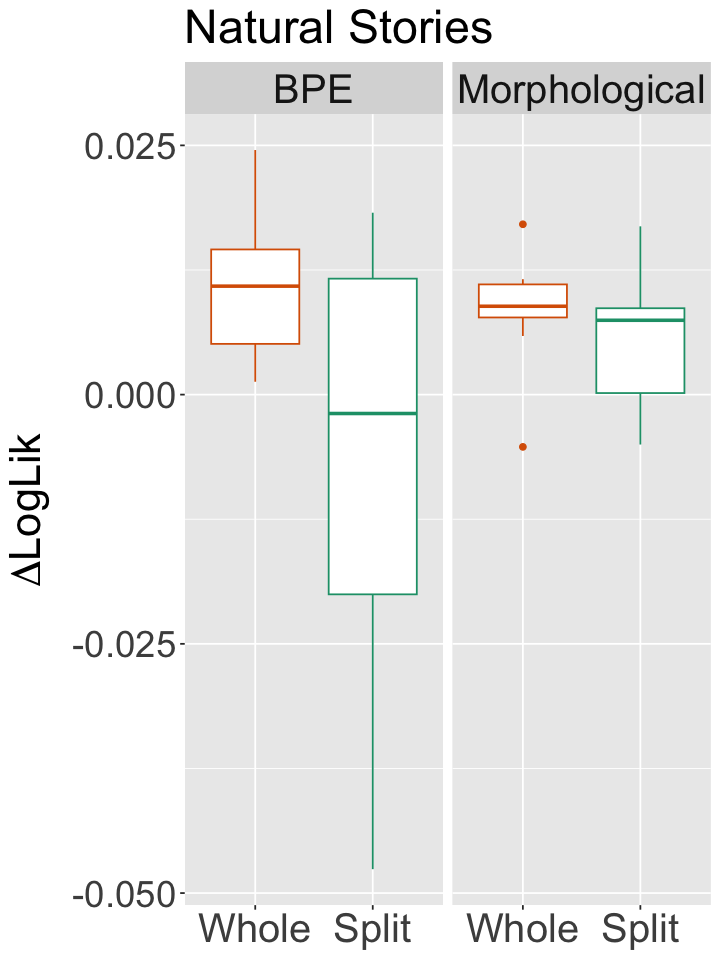

In [141]:
bpe_cv <- cv_by_split(natural_stories_spr, spr_control_formula, spr_surprisal_formula, "bpe", "num_tokens")
morph_cv <- cv_by_split(natural_stories_spr, spr_control_formula, spr_surprisal_formula, "morphological", "num_tokens")
combined_cv <- rbind(bpe_cv, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)

combined_cv <- combined_cv %>%
  mutate(tokenization_method = ifelse(tokenization_method == "orthographic", "Orthographic",
                              ifelse(tokenization_method == "bpe", "BPE",
                                     ifelse(tokenization_method == "morphological", "Morphological", tokenization_method))))
combined_cv <- combined_cv %>% 
         mutate(split = ifelse(split == "whole", "Whole",
                             ifelse(split == "split", "Split", split)))

plt <- ggplot(combined_cv, aes(x = factor(split, levels = c(sort(unique(split), decreasing = TRUE))), y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + labs(title = "Natural Stories") + theme(plot.title = 
                                                                                       element_text(size = 28))
theme <- theme(axis.title = element_text(size = 26), axis.title.x = element_blank(), axis.text.x = element_text(size = 24),
               axis.text.y = element_text(size = 22),
               strip.text.x = element_text(size = 24), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [84]:
wilcox.test(bpe_cv$whole, bpe_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  bpe_cv$whole and bpe_cv$split
W = 95, p-value = 0.0001028
alternative hypothesis: true location shift is greater than 0


In [85]:
wilcox.test(morph_cv$whole, morph_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  morph_cv$whole and morph_cv$split
W = 66, p-value = 0.1237
alternative hypothesis: true location shift is greater than 0


### Resampling from the Dundee corpus to get a Natural Stories-sized sample

It's possible the model overfit to words that were not split in the Dundee corpus. We take a smaller sample to see if there is a regression in BPE-based surprisal for multimorphemic words.

In [142]:
bpe_sample = sample_n(dundee_bpe, nrow(natural_stories_bpe))
morph_sample = sample_n(dundee_morph, nrow(natural_stories_morph))

pred_power_by_split(bpe_sample, et_control_formula, et_surprisal_formula, "bpe")

no_split,split
<dbl>,<dbl>
0.01141863,0.004836126


In [143]:
pred_power_by_split(morph_sample, et_control_formula, et_surprisal_formula, "morphological")

no_split,split
<dbl>,<dbl>
0.009034772,0.01134235


There seems to be a regression with the predictive power of BPE-based surprisals but not for surprisal over morphemes. We confirm if the whole word ratios are the same (95% for BPE, 75% for morphological).

In [144]:
nrow(bpe_sample[bpe_sample$num_tokens == 1,]) / nrow(bpe_sample)

[1] 0.9445402

In [145]:
nrow(morph_sample[morph_sample$num_tokens == 1,]) / nrow(morph_sample)

[1] 0.7604575

Using tokenization_method as id variables



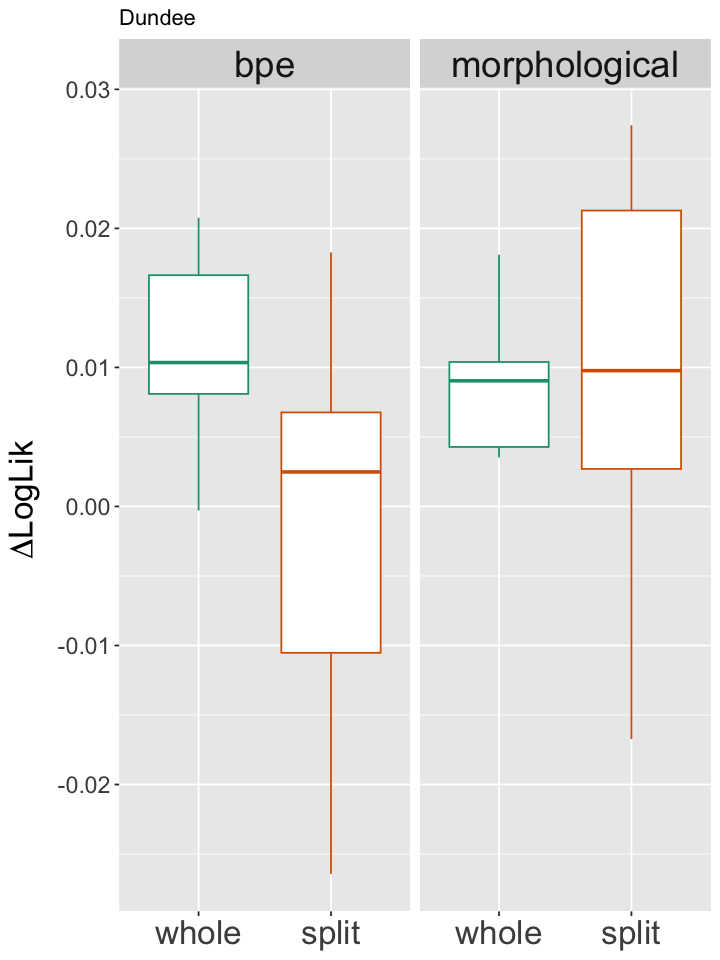

In [146]:
bpe_cv <- cv_by_split(bpe_sample, et_control_formula, et_surprisal_formula, "bpe", "num_tokens")
morph_cv <- cv_by_split(morph_sample, et_control_formula, et_surprisal_formula, "morphological", "num_tokens")
combined_cv <- rbind(bpe_cv, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)

plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Dundee")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [147]:
wilcox.test(bpe_cv$whole, bpe_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  bpe_cv$whole and bpe_cv$split
W = 80, p-value = 0.01162
alternative hypothesis: true location shift is greater than 0


In [148]:
wilcox.test(morph_cv$whole, morph_cv$split, alternative = "greater")


	Wilcoxon rank sum exact test

data:  morph_cv$whole and morph_cv$split
W = 45, p-value = 0.6579
alternative hypothesis: true location shift is greater than 0


## Running the analysis over the same sets of words

The above analyses report predictive power for different sets of words. For instance, words split by the BPE tokenizer are proper names, and those aren't split by morphemes. So we will actually need to run it on words split by morphological segmentation and words split by BPE tokenization.

In [193]:
other_tokens <- function(uid, df) {
    subset(df, token_uid == uid)$num_tokens
}

In [207]:
dundee_bpe$morph_tokens <- lapply(dundee_bpe$token_uid, other_tokens, df = dundee_morph)

In [210]:
dundee_morph$bpe_tokens <- lapply(dundee_morph$token_uid, other_tokens, df = dundee_bpe)

In [212]:
natural_stories_bpe$morph_tokens <- lapply(natural_stories_bpe$token_uid, other_tokens, df = natural_stories_morph)

In [206]:
natural_stories_morph$bpe_tokens <- lapply(natural_stories_morph$token_uid, other_tokens, df = natural_stories_bpe)

Using tokenization_method as id variables



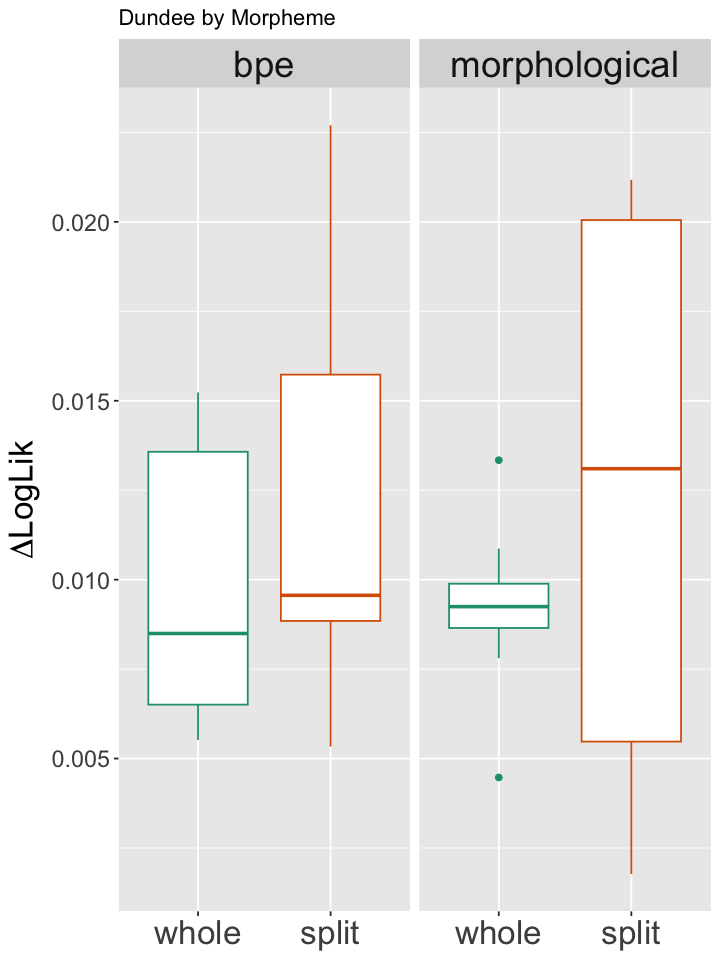

In [209]:
bpe_for_morphemes <- cv_by_split(dundee_bpe, et_control_formula, et_surprisal_formula, "bpe", "morph_tokens")
morph_cv <- cv_by_split(dundee_morph, et_control_formula, et_surprisal_formula, "morphological", "num_tokens")

combined_cv <- rbind(bpe_for_morphemes, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Dundee by Morpheme")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [264]:
wilcox.test(bpe_for_morphemes$whole, bpe_for_morphemes$split)


	Wilcoxon rank sum exact test

data:  bpe_for_morphemes$whole and bpe_for_morphemes$split
W = 47, p-value = 0.8534
alternative hypothesis: true location shift is not equal to 0


In [265]:
wilcox.test(morph_cv$whole, morph_cv$split)


	Wilcoxon rank sum exact test

data:  morph_cv$whole and morph_cv$split
W = 43, p-value = 0.6305
alternative hypothesis: true location shift is not equal to 0


Using tokenization_method as id variables



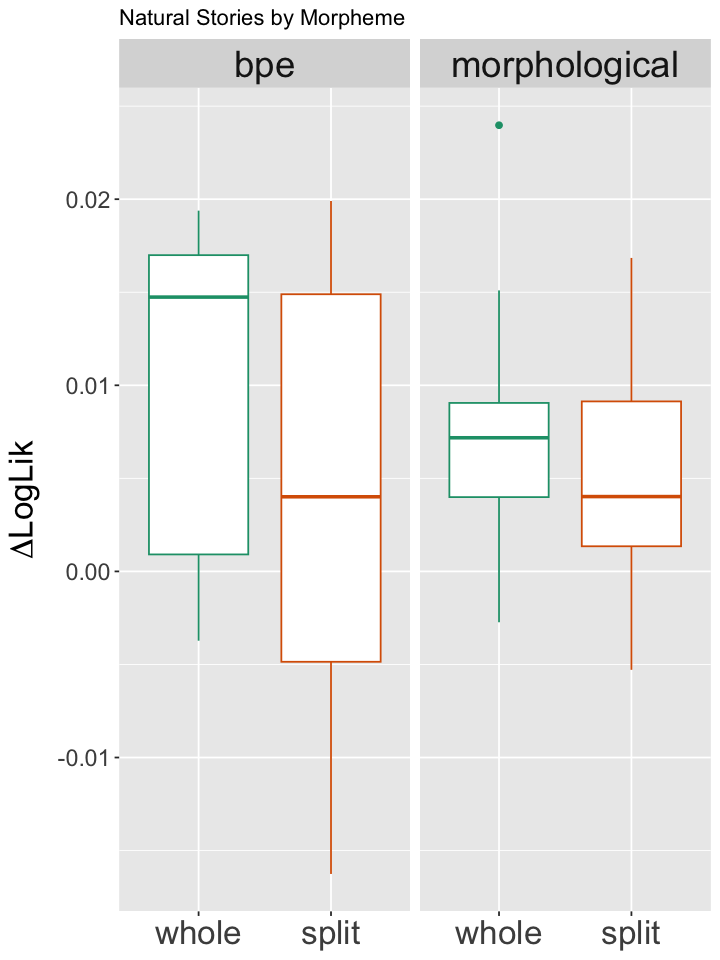

In [239]:
bpe_for_morphemes <- cv_by_split(natural_stories_bpe, spr_control_formula, spr_surprisal_formula, "bpe", "morph_tokens")
morph_cv <- cv_by_split(natural_stories_morph, spr_control_formula, spr_surprisal_formula, "morphological", "num_tokens")

combined_cv <- rbind(bpe_for_morphemes, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Natural Stories by Morpheme")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [266]:
wilcox.test(bpe_for_morphemes$whole, bpe_for_morphemes$split)


	Wilcoxon rank sum exact test

data:  bpe_for_morphemes$whole and bpe_for_morphemes$split
W = 47, p-value = 0.8534
alternative hypothesis: true location shift is not equal to 0


In [267]:
wilcox.test(morph_cv$whole, morph_cv$split)


	Wilcoxon rank sum exact test

data:  morph_cv$whole and morph_cv$split
W = 43, p-value = 0.6305
alternative hypothesis: true location shift is not equal to 0


Using tokenization_method as id variables



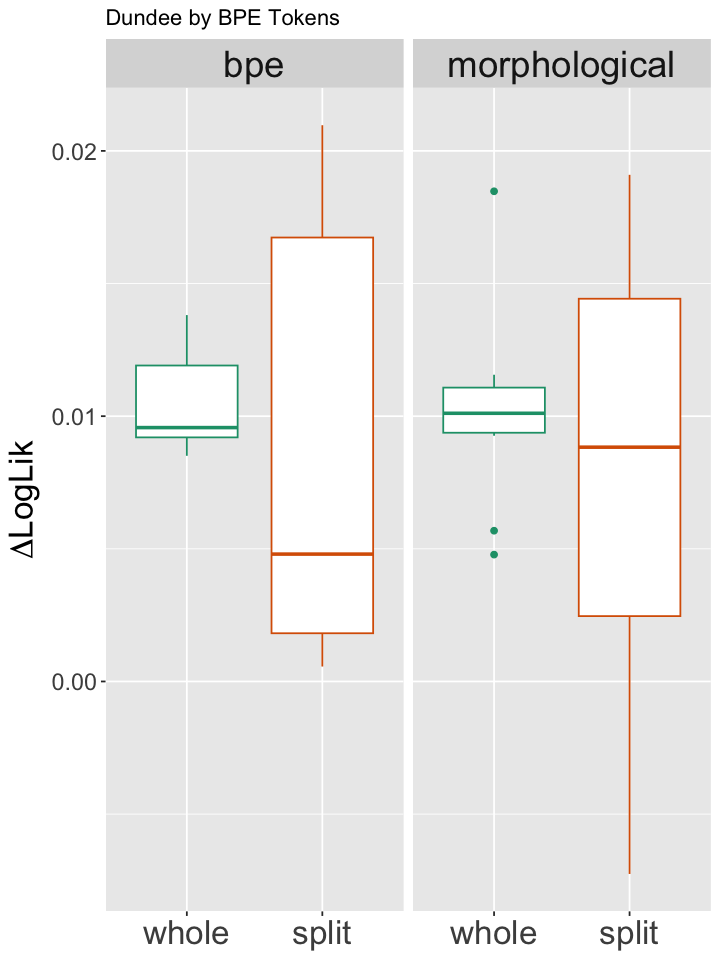

In [245]:
morph_for_bpe <- cv_by_split(dundee_morph, et_control_formula, et_surprisal_formula, "morphological", "bpe_tokens")
bpe_cv <- cv_by_split(dundee_bpe, et_control_formula, et_surprisal_formula, "bpe", "num_tokens")

combined_cv <- rbind(morph_for_bpe, bpe_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Dundee by BPE Tokens")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [248]:
wilcox.test(bpe_for_morphemes$whole, bpe_for_morphemes$split)


	Wilcoxon rank sum exact test

data:  bpe_for_morphemes$whole and bpe_for_morphemes$split
W = 63, p-value = 0.3527
alternative hypothesis: true location shift is not equal to 0


In [249]:
wilcox.test(bpe_cv$whole, bpe_cv$split)


	Wilcoxon rank sum exact test

data:  bpe_cv$whole and bpe_cv$split
W = 60, p-value = 0.4813
alternative hypothesis: true location shift is not equal to 0


Using tokenization_method as id variables



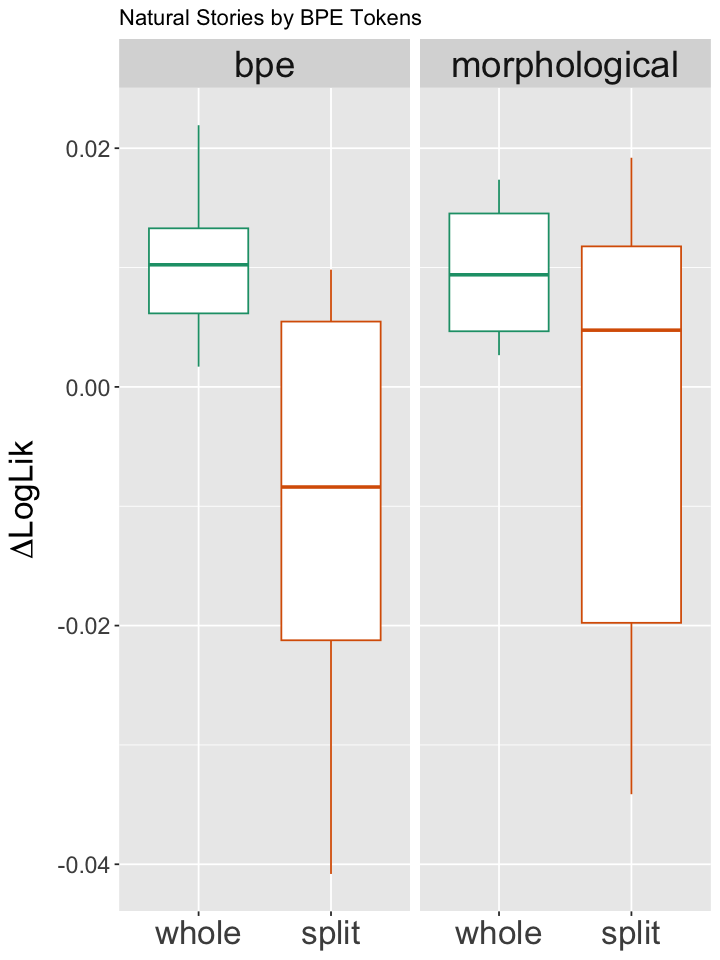

In [254]:
morph_for_bpe <- cv_by_split(natural_stories_morph, spr_control_formula, spr_surprisal_formula, "morphological", "bpe_tokens")
bpe_cv <- cv_by_split(natural_stories_bpe, spr_control_formula, spr_surprisal_formula, "bpe", "num_tokens")

combined_cv <- rbind(morph_for_bpe, bpe_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Natural Stories by BPE Tokens")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


In [258]:
wilcox.test(morph_for_bpe$whole, morph_for_bpe$split)


	Wilcoxon rank sum exact test

data:  morph_for_bpe$whole and morph_for_bpe$split
W = 67, p-value = 0.2176
alternative hypothesis: true location shift is not equal to 0


In [259]:
wilcox.test(bpe_cv$whole, bpe_cv$split)


	Wilcoxon rank sum exact test

data:  bpe_cv$whole and bpe_cv$split
W = 88, p-value = 0.002879
alternative hypothesis: true location shift is not equal to 0


## Excluding Stopwords for Morphologically Complex Words

Although we did not see the same statistically significant reduction in predictive power for morphological surprisal on words split into multiple BPE tokens, there are not that many meaningful differences in surprisal for words split into multiple morphemes. This could have to do with a lot of closed-class words being highly frequent and predictable. As a first pass at this hypothesis, we take out the surprisal.

In [260]:
dundee_morph_no_sw = filter(dundee_morph, is_stopword == "False")
dundee_bpe_no_sw = filter(dundee_bpe, is_stopword == "False")
ns_morph_no_sw = filter(natural_stories_morph, is_stopword == "False")
ns_bpe_no_sw = filter(natural_stories_bpe, is_stopword == "False")

Using tokenization_method as id variables



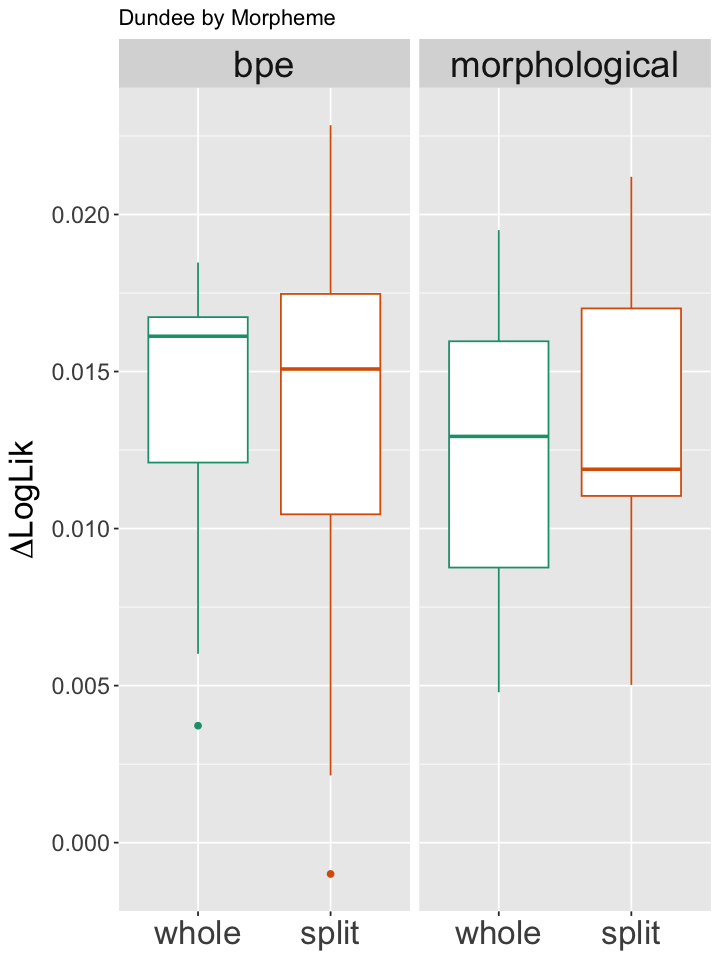

In [261]:
bpe_for_morphemes <- cv_by_split(dundee_bpe_no_sw, et_control_formula, et_surprisal_formula, "bpe", "morph_tokens")
morph_cv <- cv_by_split(dundee_morph_no_sw, et_control_formula, et_surprisal_formula, "morphological", "num_tokens")

combined_cv <- rbind(bpe_for_morphemes, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Dundee by Morpheme")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


Using tokenization_method as id variables



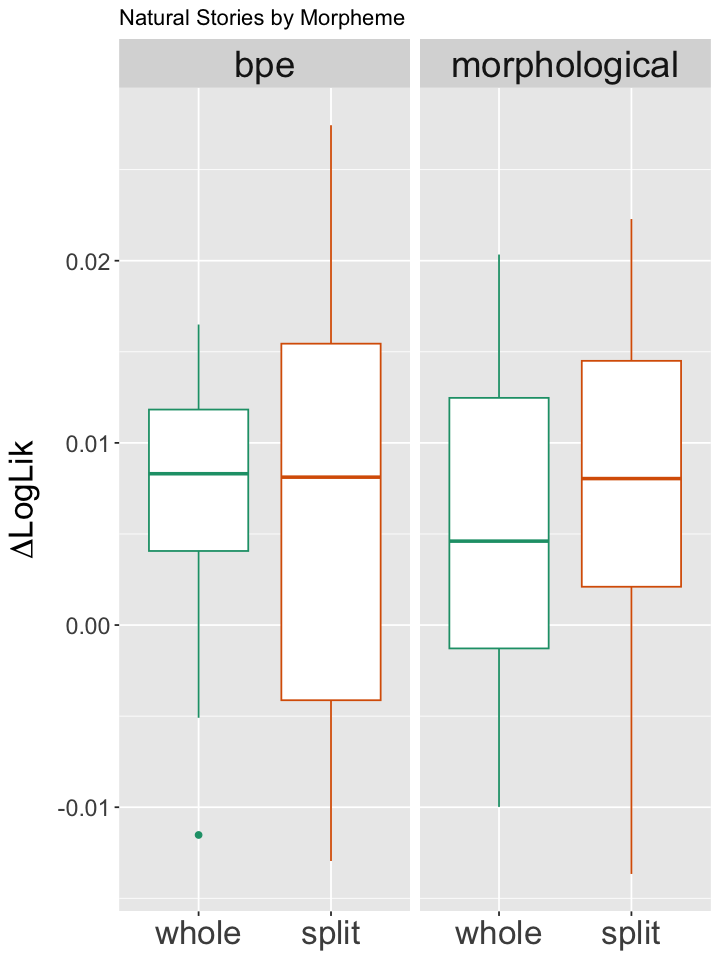

In [263]:
bpe_for_morphemes <- cv_by_split(ns_bpe_no_sw, et_control_formula, et_surprisal_formula, "bpe", "morph_tokens")
morph_cv <- cv_by_split(ns_morph_no_sw, et_control_formula, et_surprisal_formula, "morphological", "num_tokens")

combined_cv <- rbind(bpe_for_morphemes, morph_cv)
combined_cv <- melt(combined_cv) %>% rename(split = variable)
plt <- ggplot(combined_cv, aes(x = split, y = value, color = split)) + geom_boxplot()
plt <- plt + ylab(expression(paste(Delta, "LogLik"))) + ggtitle("Natural Stories by Morpheme")
theme <- theme(axis.title = element_text(size = 20), axis.title.x = element_blank(), axis.text.x = element_text(size = 20),
               axis.text.y = element_text(size = 14),
               strip.text.x = element_text(size = 22), legend.position = "none")
plt + facet_grid(. ~tokenization_method) + theme + labs(fill = "tokenization_method") + scale_color_brewer(palette = "Dark2")


## Slowdown in reading time due to surprisal 

Replicating the qualitative results from Wilcox et al (2020) on the relationship between surprisal and reading time. For each LM, we fit a generalized additive model (GAM) and plot the slowdown in a word's reading time due to surprisal. The plotting functionality with the `mgcViz` library was not compatible with other `ggplot`-based tools to make a figure with a grid.

Wilcox et al (2020) plotted the slowdown aggregated over all previous tokens, but there are related plots in Smith and Levy (2013). 

In [108]:
library(mgcViz)

Loading required package: mgcv

Loading required package: nlme




Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.

Loading required package: qgam

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'mgcViz':
  method from  
  +.gg   GGally


Attaching package: 'mgcViz'


The following objects are masked from 'package:stats':

    qqline, qqnorm, qqplot




In [142]:
plot_gam <- function(data, color_index, plot_title, corpus) {
    rt_surprisal_gam <- gam(rt ~ s(surprisal, bs = "cr", k = 20) + s(prev_surprisal_1, bs = "cr", k = 20)
                + te(log_freq, word_length, bs = "cr") + te(prev_freq_1, prev_len_1, bs = "cr"), data=data)

    if (corpus == "natural_stories") {
        rt_surprisal_gam <- gam(rt ~ s(surprisal, bs = "cr", k = 20) + s(prev_surprisal_1, bs = "cr", k = 20) 
                + s(prev_surprisal_2, bs = 'cr', k = 20) + s(prev_surprisal_3, bs = 'cr', k = 20)
                + te(log_freq, word_length, bs = "cr") + te(prev_freq_1, prev_len_1, bs = "cr") 
                + te(prev_freq_2, prev_len_2, bs = 'cr') + te(prev_freq_3, prev_len_3, bs = 'cr'), data=data)
    }
    # formula from pg 3 of https://arxiv.org/pdf/2006.01912.pdf (Wilcox et al 2020)
    plot(getViz(rt_surprisal_gam), select = 1, xlab = "surprisal", ylab = "slowdown") + l_fitLine(color = color_index) + l_ciLine(color = color_index) + 
    theme_get() + labs(x = "Surprisal", y = "Slowdown in Reading Time (ms)", title = plot_title)
}



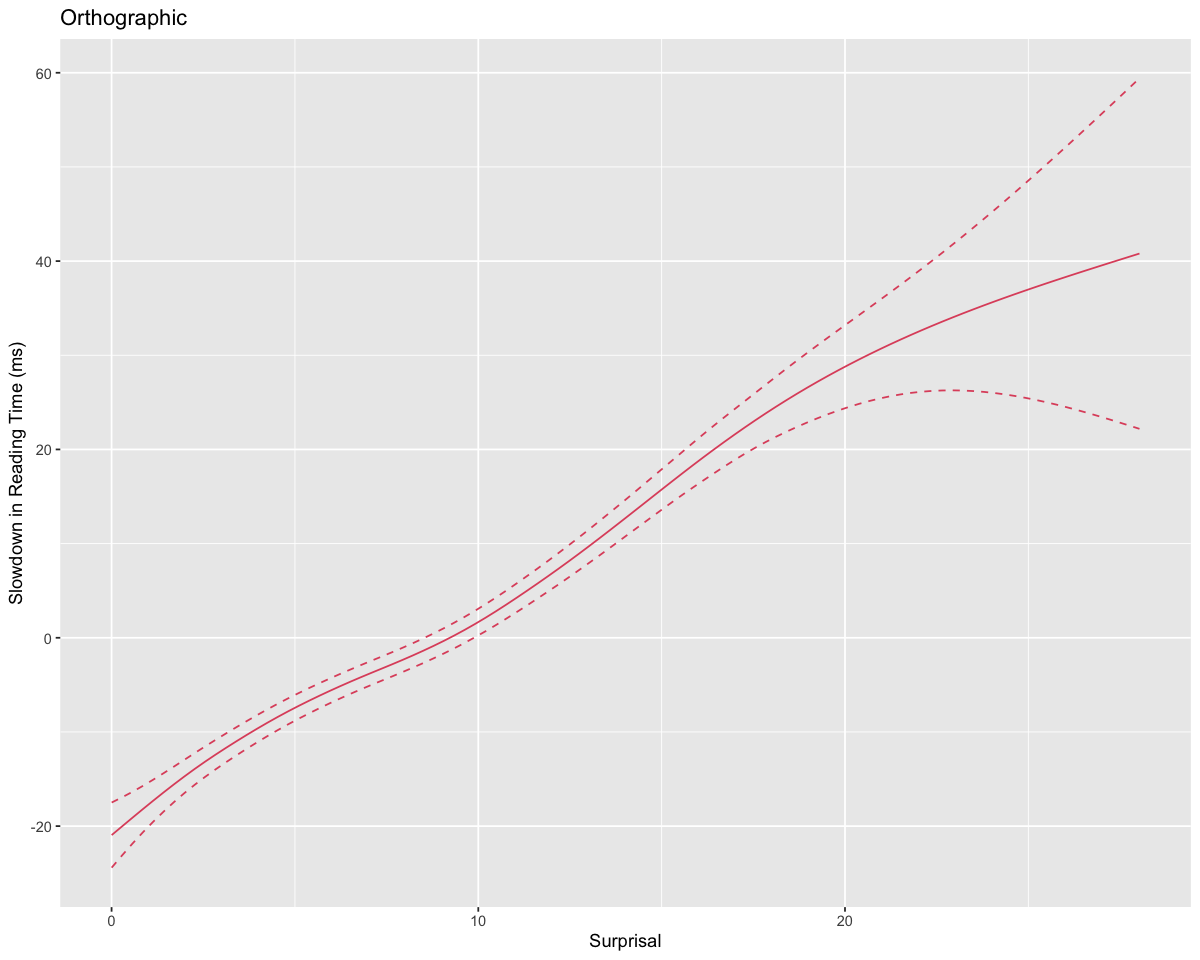

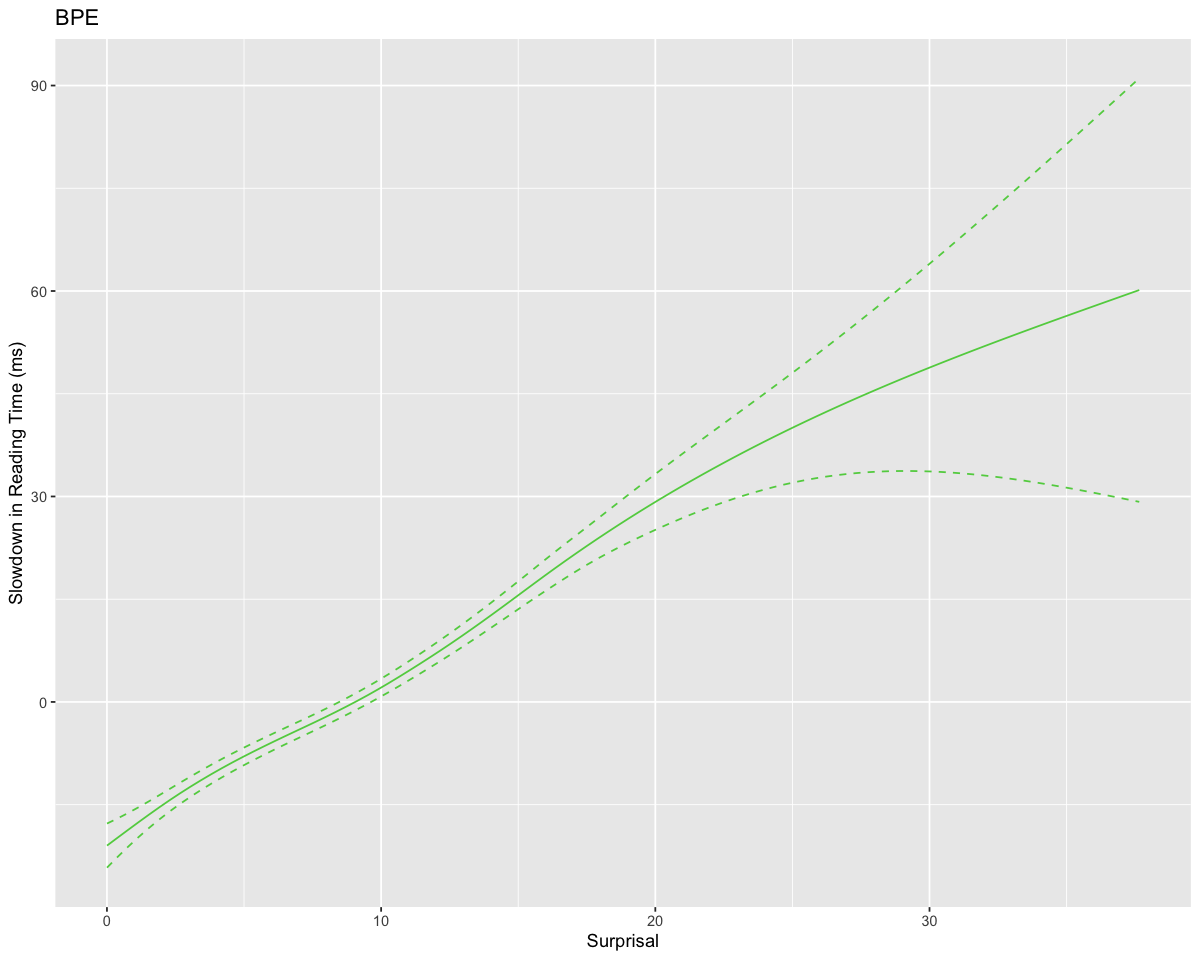

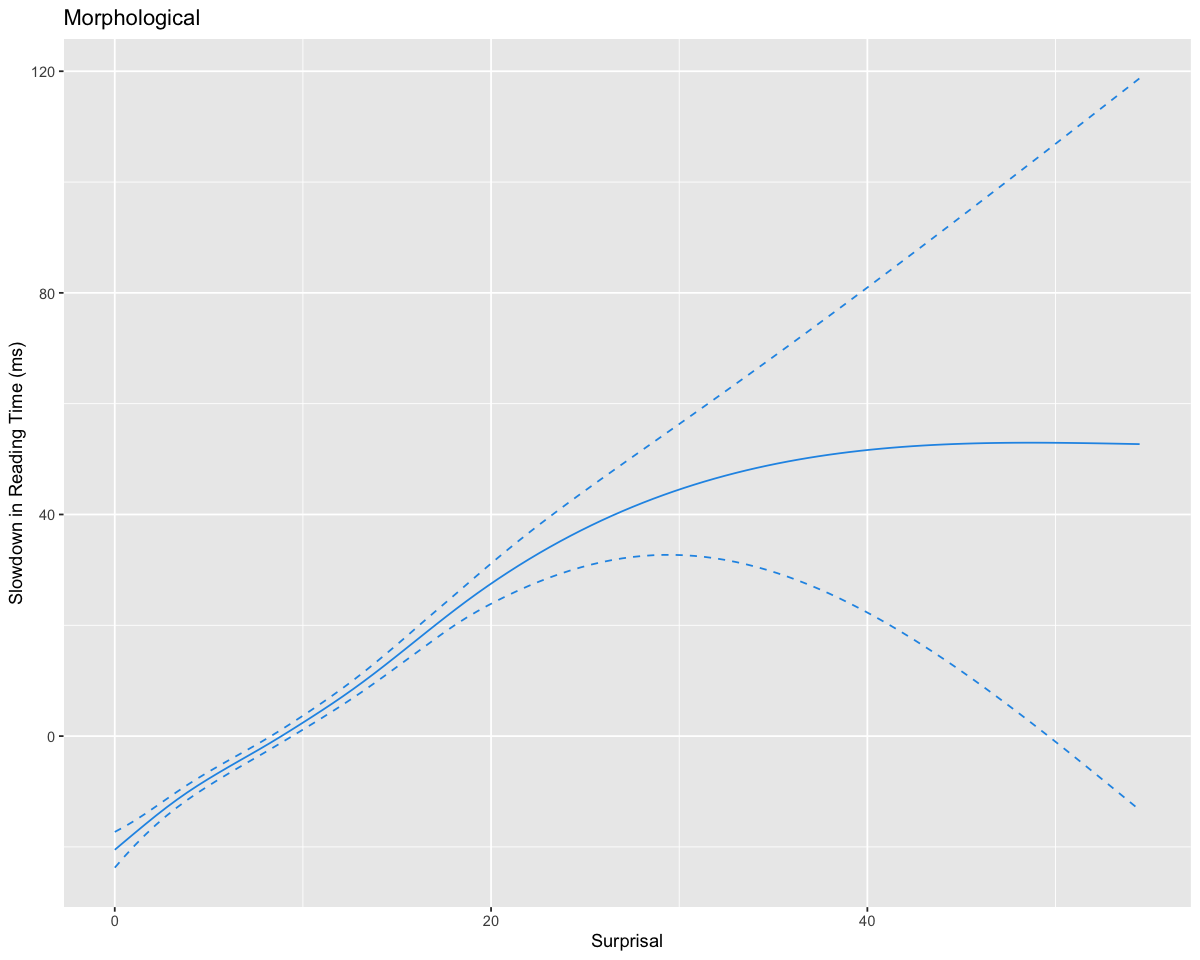

In [143]:
plot_gam(dundee_orth, 2, "Orthographic", "dundee")
plot_gam(dundee_bpe, 3, "BPE", "dundee")
plot_gam(dundee_morph, 4, "Morphological", "dundee")

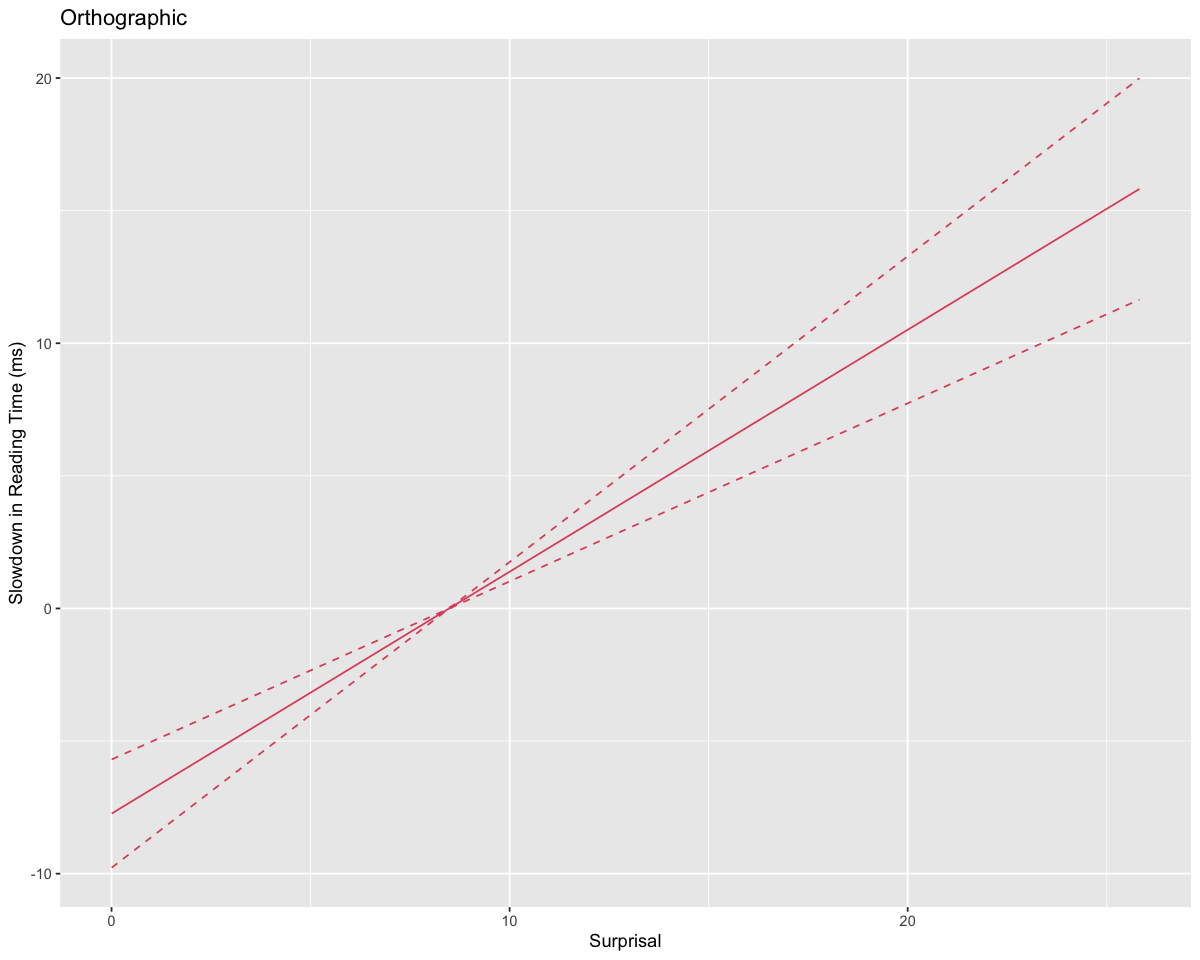

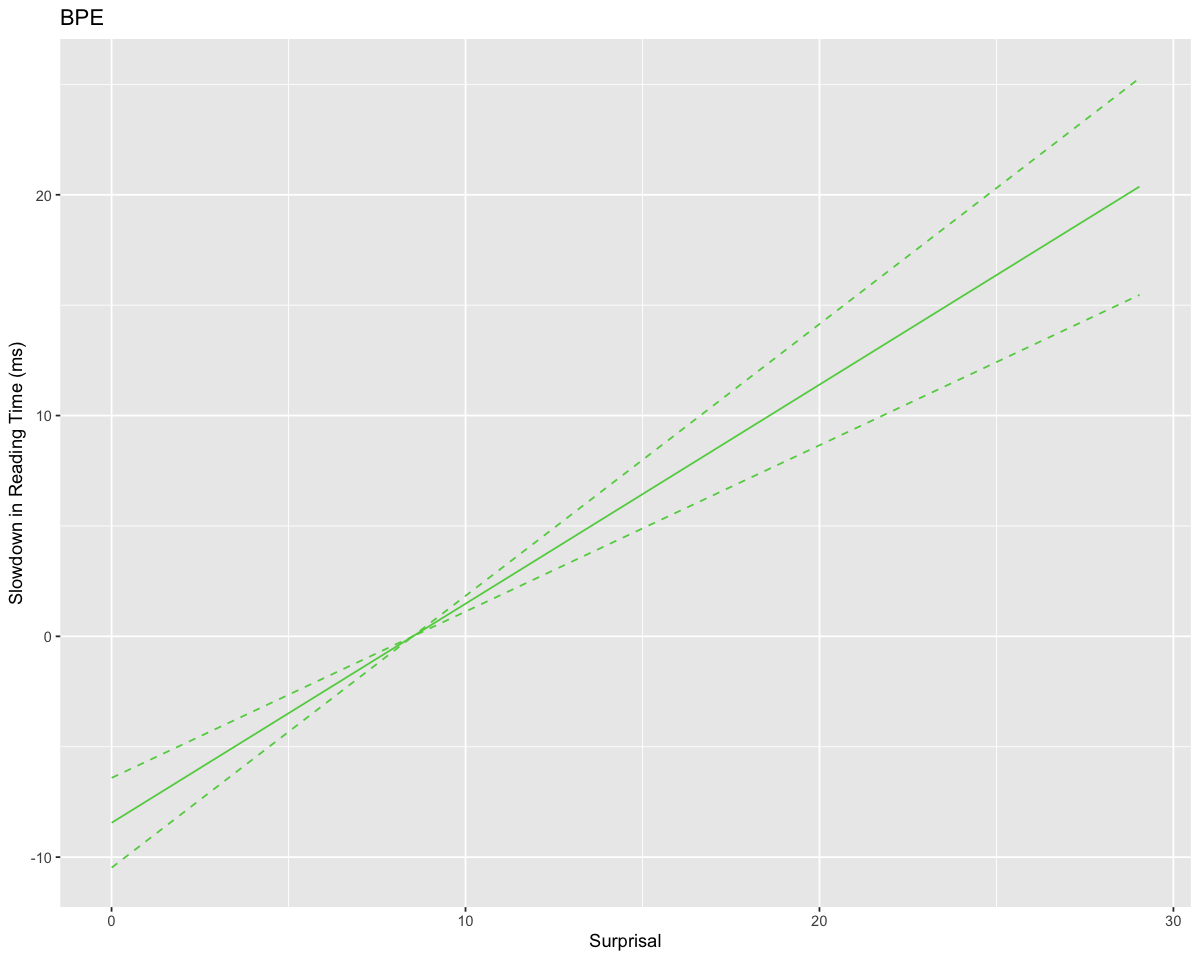

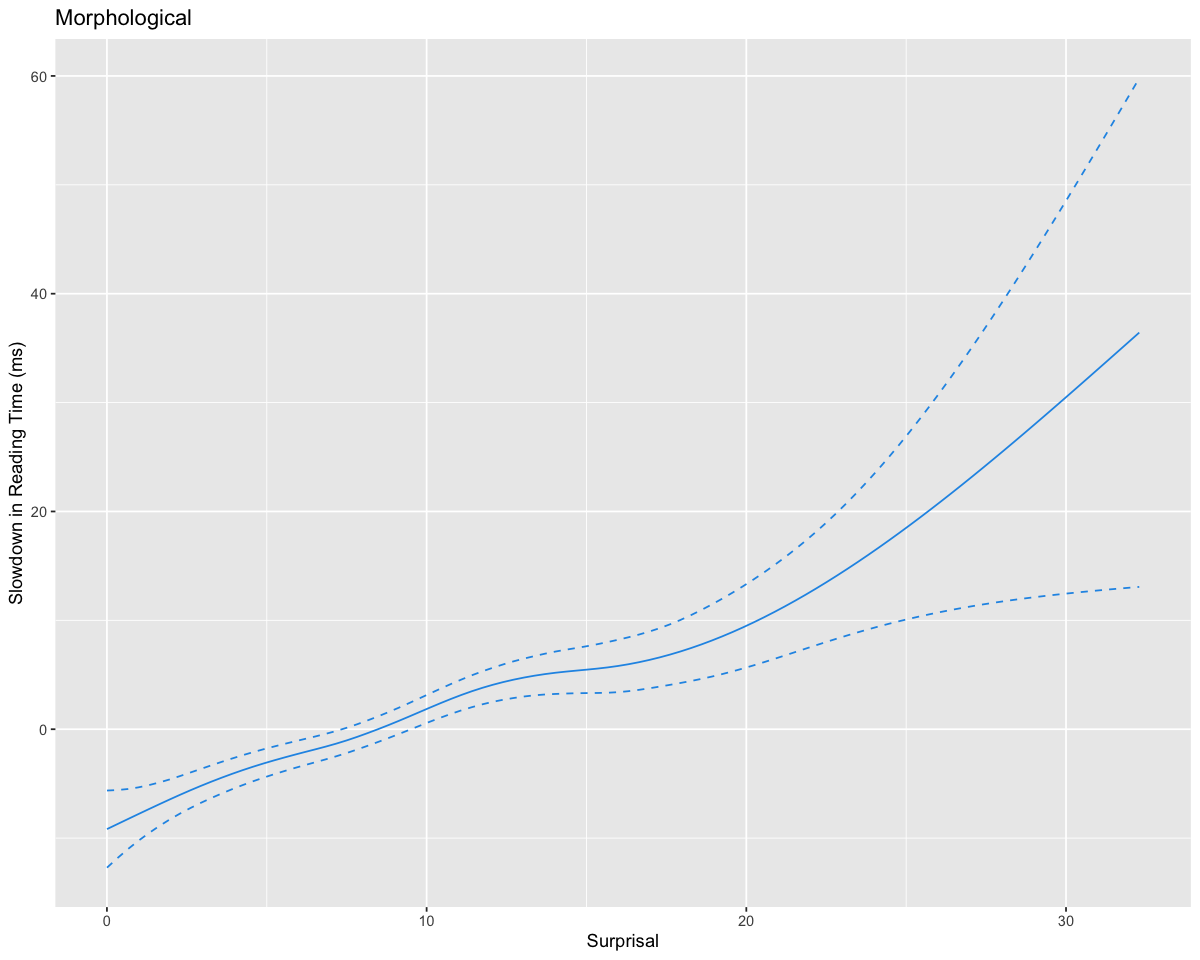

In [144]:
plot_gam(natural_stories_orth, 2, "Orthographic", "dundee")
plot_gam(natural_stories_bpe, 3, "BPE", "dundee")
plot_gam(natural_stories_morph, 4, "Morphological", "dundee")